## Calculating Multimodel Embeddings for XKCD Using `nomic-embed`

In [4]:
import os
import urllib
import time

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import polars as pl

Setup functions to calculate embeddings from images or text

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
processor = AutoImageProcessor.from_pretrained("nomic-ai/nomic-embed-vision-v1.5")
vision_model = AutoModel.from_pretrained(
    "nomic-ai/nomic-embed-vision-v1.5", trust_remote_code=True
).to(device)


def calculate_image_embeddings(image_paths: list[str]):
    images = [Image.open(path) for path in image_paths]
    inputs = processor(images, return_tensors="pt")
    # Move inputs to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    image_emb = vision_model(**inputs).last_hidden_state
    return F.normalize(image_emb[:, 0], p=2, dim=1)


tokenizer = AutoTokenizer.from_pretrained("nomic-ai/nomic-embed-text-v1.5")
text_model = AutoModel.from_pretrained(
    "nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True
).to(device)
text_model.eval()


def calculate_text_embeddings(text_chunks: list[str]):
    encoded_input = tokenizer(
        text_chunks, padding=True, truncation=True, return_tensors="pt"
    )
    # Move inputs to GPU
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    with torch.no_grad():
        model_output = text_model(**encoded_input)

    text_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
    text_embeddings = F.layer_norm(
        text_embeddings, normalized_shape=(text_embeddings.shape[1],)
    )
    return F.normalize(text_embeddings, p=2, dim=1)


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

Encountered exception while importing einops: No module named 'einops'


ImportError: This modeling file requires the following packages that were not found in your environment: einops. Run `pip install einops`

Test the embedding models are working

In [246]:
image_embeddings = calculate_image_embeddings(
    ["test-images/cats.jpg", "test-images/desert.jpg"]
)
query_embedding = calculate_text_embeddings(
    ["search_query:an animal that’s nice to cuddle with"]
)

image_embeddings @ query_embedding.T

tensor([[0.0667],
        [0.0367]], device='cuda:0', grad_fn=<MmBackward0>)

Utility function to plot a square matrix of cosine similarities

In [289]:
def plot_similarity(
    matrix, start_index=0, xlabel="Vector Index", ylabel="Vector Index"
):
    plt.clf()
    plt.imshow(matrix, cmap="YlOrRd")

    plt.rcParams.update({"font.size": 14})

    # Generate axis labels
    size = len(matrix)
    indices = [start_index + i for i in range(size)]

    # Calculate appropriate tick spacing
    tick_spacing = max(size // 5, 1)  # Show ~5 ticks, minimum of 1
    tick_positions = range(0, size, tick_spacing)
    tick_labels = [indices[i] for i in tick_positions]

    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels)

    # Add colorbar
    plt.colorbar(label="Cosine Similarity Score")

    plt.title("Similarity Matrix")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()

Fetch Data of 'all' XKCDs including image URL and explanation text from explainxkcd.com and store in an in-memory duckdb database

In [ ]:
duckdb.sql(
    "create table xkcd as select * from \
        'https://huggingface.co/datasets/olivierdehaene/xkcd/resolve/refs%2Fconvert%2Fparquet/default/train/0000.parquet' \
        "
)

Pick 30 XKCDs to test and experiment with (starting at 1500 as the first few comics are atypical)

In [272]:
test_comics = duckdb.sql(
    "select id, image_url, explanation \
    from xkcd \
    limit 40 offset 1200;"
).pl()

For each of the XKCDs to experiment with, store the image on disk so we can calculate an embedding

In [273]:
for comic in test_comics.to_dicts():
    filename = f"xkcd-images/{comic["id"]}.jpg"
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(comic["image_url"], filename)

Calculate an embedding of the image using our utility function for each image

In [285]:
test_comic_embeddings = calculate_image_embeddings(
    [f"xkcd-images/{xkcd_id}.jpg" for xkcd_id in test_comics["id"]]
)

Calculate an embedding of the explanation text (which include a transcript)

In [284]:
test_explanation_embeddings = calculate_text_embeddings(
    [f"search_document:{explanation}" for explanation in test_comics["explanation"]]
)

Calculate a dot product between each XCKDs image and description (which is cosine similarity score as they are unit norm)

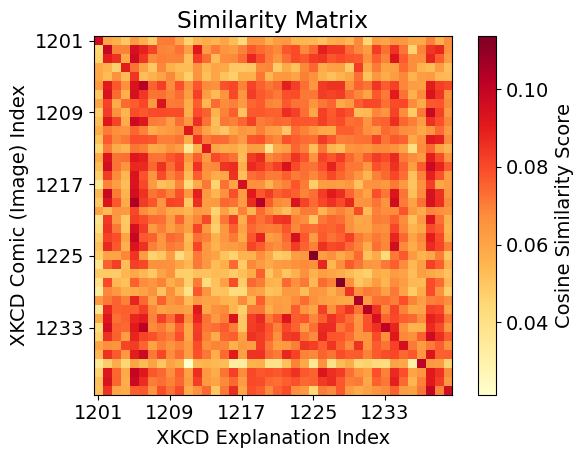

In [297]:
with torch.no_grad():
    result = test_comic_embeddings @ test_explanation_embeddings.T
    # move to cpu in case we used gpu to calculate embeddings
    result = result.cpu()

    plot_similarity(
        result,
        start_index=test_comics["id"][0],
        xlabel="XKCD Explanation Index",
        ylabel="XKCD Comic (Image) Index",
    )
    # plt.savefig("matrix.png", dpi=270)

### Generating embeddings for all the comics

We're going to want to persist the embeddings. I am attaching a separate duckdb database (from a file) so that I have the embeddings in the file. I can keep the xkcd table in memory as that is easy to download again and I don't want to bloat the size of my embedding db with the source text. Either work though.

In [ ]:
duckdb.sql("ATTACH 'embeddings.db' as embed_db;")
# You don't need to use ATTACH like this, but this means I can have an in-memory table of the source data (xkcd table)
# that won't persist and a table of vectors that I want to persist in a file at the same time.

Simple table that stores just the comic id and image and text vectors

In [280]:
duckdb.sql(
    """
    CREATE TABLE IF NOT EXISTS embed_db.xkcd_vectors( 
        id INT PRIMARY KEY, 
        image_embedding FLOAT[768], 
        text_embedding FLOAT[768] 
    );"""
)

We will chunk the embedding process so we don't run out of memory.

The loop is a fairly simple process:
1. Find ids of comics we haven't already embedded.
2. For those ids, check we have an image locally and download it (and sleep as a very crude rate limiter to be kind to XKCD's website).
3. Calculate embeddings for all the images and all the embeddings in the chunk. This does multiple images at once so the embedding inference happend in parallel on the GPU.
4. Store the embeddings into our duckdb database.

The for loop could be a while true but I wanted to do 10 chunks and check the progress. The code is idempotent, so we can do 10 chunks, and it will start again where it left off last time.

In [197]:
count_fetched = 0
chunk_size = 20  # 20 comics at a time

for i in range(10):
    comics_to_embed = duckdb.execute(
        "select id, image_url, explanation \
        from xkcd \
        where xkcd.id not in ( \
            select id from embed_db.xkcd_vectors \
        ) \
        and image_url is not null \
        and image_url != 'https://imgs.xkcd.com/comics/' \
        limit ?;",
        [chunk_size],
    ).pl()

    if len(comics_to_embed) == 0:
        print("No comics to embed.")
        break

    for comic in comics_to_embed.to_dicts():
        filename = f"xkcd-images/{comic["id"]}.jpg"
        if not os.path.isfile(filename):
            try:
                urllib.request.urlretrieve(comic["image_url"], filename)
                # Crude rate limit for XKCD website - be nice
                time.sleep(0.2)
                count_fetched = count_fetched + 1
            except TypeError:
                print(comic["id"], comic["image_url"])

    comic_embeddings = calculate_image_embeddings(
        [f"xkcd-images/{xkcd_id}.jpg" for xkcd_id in comics_to_embed["id"]]
    )

    explanation_embeddings = calculate_text_embeddings(
        [f"search_document:{text}" for text in comics_to_embed["explanation"]]
    )

    # Add 2 columns to the polars dataframe for the image and text embeddings
    comics_to_embed = comics_to_embed.with_columns(
        pl.Series(name="image_embedding", values=comic_embeddings.cpu().tolist()),
        pl.Series(name="text_embedding", values=explanation_embeddings.cpu().tolist()),
    )

    # Use the duckdb Python integration, which can load data from a Polars dataframe
    # referred to by a Python variable.
    # This is MUCH faster than using executemany or a loop.
    duckdb.execute(
        "insert into embed_db.xkcd_vectors from \
        (select id, image_embedding, text_embedding from comics_to_embed); "
    )
    print(
        f"Inserted {len(comics_to_embed)} comics: {comics_to_embed["id"].min()} to {comics_to_embed["id"].max()}. "
        f"Images fetched: {count_fetched}"
    )

No comics to embed.


### Query the embeddings: compare text description with query text

Use the same helper function to calculate a query embedding.

Use the duckdb `array_cosine_similarity` to sort the database embeddings, take the top few.

In [306]:
query_string = (
    "search_query:there are lots of different competing vector databases "
    "let's make one to become the standard"
)
query_vector = calculate_text_embeddings([query_string]).tolist()[0]

duckdb.execute(
    "select xkcd.id, xkcd.title, \
    array_cosine_similarity(text_embedding, ?::float[768]) as similarity \
    from embed_db.xkcd_vectors \
    join xkcd on xkcd.id = embed_db.xkcd_vectors.id \
    order by similarity desc \
    limit 3;",
    [query_vector],
).pl()

id,title,similarity
i64,str,f32
927,"""Standards""",0.701464
2116,""".NORM Normal File Format""",0.653827
2254,"""JPEG2000""",0.644123


Another example

In [228]:
query_string = "search_query:how have you never heard of this before?"
query_vector = calculate_text_embeddings([query_string]).tolist()[0]

duckdb.execute(
    "select xkcd.id, xkcd.title, \
    array_cosine_similarity(text_embedding, ?::float[768]) as similarity \
    from embed_db.xkcd_vectors \
    join xkcd on xkcd.id = embed_db.xkcd_vectors.id \
    order by similarity desc \
    limit 3;",
    [query_vector],
).pl()

id,title,similarity
i64,str,f32
1053,"""Ten Thousand""",0.617261
1355,"""Airplane Message""",0.601863
674,"""Natural Parenting""",0.601047


### Query the embeddings: compare xkcd image embeddings with query images

Use the image helper function to calculate a query vector for a local image 

In [309]:
query_image_embedding = calculate_image_embeddings(
    ["test-images/gromit-reading-the-paper.jpeg"]
).tolist()[0]

duckdb.execute(
    "select xkcd.id, xkcd.title, \
    array_cosine_similarity(image_embedding, ?::float[768]) as similarity \
    from embed_db.xkcd_vectors \
    join xkcd on xkcd.id = embed_db.xkcd_vectors.id \
    order by similarity desc \
    limit 3;",
    [query_image_embedding],
).pl()

id,title,similarity
i64,str,f32
799,"""Stephen Hawking""",0.910966
750,"""Book Burning""",0.901851
997,"""Wait Wait""",0.897447


### Query the embeddings: compare xkcd images to query text embeddings

In [229]:
query_string = "search_query:car"
query_vector = calculate_text_embeddings([query_string]).tolist()[0]

duckdb.execute(
    "select xkcd.id, xkcd.title, \
    (array_cosine_similarity(image_embedding, ?::float[768])) as similarity \
    from embed_db.xkcd_vectors \
    join xkcd on xkcd.id = embed_db.xkcd_vectors.id \
    order by similarity desc \
    limit 3;",
    [query_vector],
).pl()

id,title,similarity
i64,str,f32
80,"""My Other Car""",0.081244
37,"""Hyphen""",0.08113
2064,"""I'm a Car""",0.078028


### Query the embeddings: comparing query text to xkcd images and text at the same time

In [325]:
query_string = "search_query:bananas"
query_vector = calculate_text_embeddings([query_string]).tolist()[0]

result = duckdb.execute(
    "select xkcd.id, xkcd.title,  \
    (array_cosine_similarity(image_embedding, $vector::float[768])) as image_similarity, \
    (array_cosine_similarity(text_embedding, $vector::float[768])) as text_similarity, \
    (0.7 * image_similarity + 0.3 * text_similarity) as combined_similarity \
    from embed_db.xkcd_vectors \
    join xkcd on xkcd.id = embed_db.xkcd_vectors.id \
    order by combined_similarity desc \
    limit 3;",
    {"vector": query_vector},
).pl()

with pl.Config(
    tbl_formatting="MARKDOWN",
    tbl_hide_column_data_types=True,
    tbl_hide_dataframe_shape=True,
):

    print(result)

| id   | title                   | image_similarity | text_similarity | combined_similarity |
|------|-------------------------|------------------|-----------------|---------------------|
| 1949 | Fruit Collider          | 0.055841         | 0.663562        | 0.238157            |
| 388  | Fuck Grapefruit         | 0.05881          | 0.622837        | 0.228018            |
| 236  | Collecting Double-Takes | 0.041912         | 0.645767        | 0.223069            |
